In [100]:
import pandas as pd
import os
import numpy as np
from sklearn import model_selection
from tqdm import tqdm_gui
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

import cv2
import random
from tqdm import tqdm

torch.manual_seed(100)
random.seed(100)

### config

In [101]:
class Config(object):
    def __init__(self) -> None:
        self.datasetdir = "/media/beyond/70f23ead-fa6d-4628-acf7-c82133c03245/home/beyond/Documents/ml/data/dataset/image/VOCdevkit/VOC2012"
        
        self.size = 512
        self.batch_size = 1

        self.lr = 1e-3
        self.epochs = 100

        self.max_interset_iou = 0.1
        self.min_confidence = 0.5

        self.classlist = [
            'aeroplane', 'bicycle', 'bird', 'boat',
            'bottle', 'bus', 'car', 'cat', 'chair',
            'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant',
            'sheep', 'sofa', 'train', 'tvmonitor']
        
        self.device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")



config = Config()

### utils

In [102]:

import xml.etree.ElementTree as ET
import os

def parse_rec(filename:str):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    result = {}
    result["filename"] = filename[filename.rindex("/")+1:-4]
    result["width"] = int(tree.find("size").find("width").text)
    result["height"] = int(tree.find("size").find("height").text)
    result["boxes"] = []
    for object in tree.findall('object'):
        obj = {}
        # difficult = int(object.find('difficult').text)
        # if difficult == 1:
        #     continue
        obj['classname'] = object.find('name').text
        bbox = object.find('bndbox')
        obj['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text)),
                              int(float(bbox.find('ymax').text))]
        result["boxes"].append(obj)
    return result


axmlpath = os.path.join(config.datasetdir, "Annotations","2010_006026.xml")
parse_rec(axmlpath)

{'filename': '2010_006026',
 'width': 332,
 'height': 500,
 'boxes': [{'classname': 'sheep', 'bbox': [87, 412, 147, 463]},
  {'classname': 'sheep', 'bbox': [100, 353, 144, 382]},
  {'classname': 'sheep', 'bbox': [141, 373, 183, 389]}]}

### dataset

In [103]:


class MyDataset(Dataset):
    image_size = 448

    def __init__(self, config:Config, transform = [], istrain=True):
        print('loading annotations')
        self.config = config
        self.istrain = istrain
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.S = 7  # grid number 7*7 normally
        self.B = 2  # bounding box number in each grid
        self.C = 20  # how many classes
        self.mean = (123, 117, 104)  # RGB
        annodir = os.path.join(config.datasetdir, "Annotations")
        i = 0
        for filename in tqdm(os.listdir(annodir)):
            # for test
            if i > 5000:
                break
            rect = parse_rec(os.path.join(annodir, filename))
            self.fnames.append(rect["filename"] + ".jpg") 
            boxes = []
            label = []
            for box in rect["boxes"]:
                x1 = box["bbox"][0]
                y1 = box["bbox"][1]
                x2 = box["bbox"][2]
                y2 = box["bbox"][3]
                boxes.append([x1, y1, x2, y2])
                label.append(config.classlist.index(box["classname"]))
            self.boxes.append(torch.Tensor(boxes))
            self.labels.append(torch.LongTensor(label))
            i = i + 1
        # self.num_samples = len(self.boxes)
        self.num_samples = min(len(self.fnames),i)

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(config.datasetdir, "JPEGImages", fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()
        if self.istrain:  # 数据增强里面的各种变换用torch自带的transform是做不到的，因为对图片进行旋转、随即裁剪等会造成bbox的坐标也会发生变化，所以需要自己来定义数据增强
            img, boxes = self.random_flip(img, boxes)
            img, boxes = self.randomScale(img, boxes)
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img, boxes, labels = self.randomShift(img, boxes, labels)
            img, boxes, labels = self.randomCrop(img, boxes, labels)
        h, w, _ = img.shape
        boxes /= torch.Tensor([w, h, w, h]).expand_as(boxes)         # 坐标 归一化 处理，为了方便训练
        img = self.BGR2RGB(img)                                                                           # because pytorch pretrained model use RGB
        # img = self.subMean(img, self.mean)                          # 减去均值
        img = cv2.resize(img, (self.image_size, self.image_size))   # 将所有图片都resize到指定大小
        img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])(img)
        target = self.encoder(boxes, labels)                        # 将图片标签编码到7x7*30的向量

        for t in self.transform:
            img = t(img)
        return img, target

    def __len__(self):
        return self.num_samples

    def encoder(self, boxes, labels):
        '''
        boxes (tensor) [[x1,y1,x2,y2],[]]  归一化后的结果
        labels (tensor) [...]
        return 7x7x30
        '''
        grid_num = 7
        target = torch.zeros((grid_num, grid_num, 30))
        cell_size = 1. / grid_num                         # 每个格子的大小

        # 右下坐标        左上坐标
        # x2,y2           x1,y1
        wh = boxes[:, 2:] - boxes[:, :2]

        # 物体中心坐标集合
        cxcy = (boxes[:, 2:] + boxes[:, :2]) / 2
        for i in range(cxcy.size()[0]):
            # 物体中心坐标
            cxcy_sample = cxcy[i]
            ij = cxcy_sample // cell_size
            xy = ij * cell_size
            delta_xy = (cxcy_sample - xy) / cell_size
            target[int(ij[1]), int(ij[0]), :2] = delta_xy
            target[int(ij[1]), int(ij[0]), 2:4] = wh[i]
            target[int(ij[1]), int(ij[0]), 5:7] = delta_xy
            target[int(ij[1]), int(ij[0]), 7:9] = wh[i]

            # 第一/二个框的置信度
            target[int(ij[1]), int(ij[0]), 4] = 1
            target[int(ij[1]), int(ij[0]), 9] = 1

            target[int(ij[1]), int(ij[0]), int(labels[i]) + 10] = 1
        return target

    def BGR2RGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    def BGR2HSV(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    def HSV2BGR(self, img):
        return cv2.cvtColor(img, cv2.COLOR_HSV2BGR)

    def RandomBrightness(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            v = v * adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomSaturation(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            s = s * adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomHue(self, bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h, s, v = cv2.split(hsv)
            adjust = random.choice([0.5, 1.5])
            h = h * adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h, s, v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def randomBlur(self, bgr):
        if random.random() < 0.5:
            bgr = cv2.blur(bgr, (5, 5))
        return bgr

    def randomShift(self, bgr, boxes, labels):
        # 平移变换
        center = (boxes[:, 2:] + boxes[:, :2]) / 2
        if random.random() < 0.5:
            height, width, c = bgr.shape
            after_shfit_image = np.zeros((height, width, c), dtype=bgr.dtype)
            after_shfit_image[:, :, :] = (104, 117, 123)  # bgr
            shift_x = random.uniform(-width * 0.2, width * 0.2)
            shift_y = random.uniform(-height * 0.2, height * 0.2)
            # print(bgr.shape,shift_x,shift_y)
            # 原图像的平移
            if shift_x >= 0 and shift_y >= 0:
                after_shfit_image[int(shift_y):,
                                  int(shift_x):,
                                  :] = bgr[:height - int(shift_y),
                                           :width - int(shift_x),
                                           :]
            elif shift_x >= 0 and shift_y < 0:
                after_shfit_image[:height + int(shift_y),
                                  int(shift_x):,
                                  :] = bgr[-int(shift_y):,
                                           :width - int(shift_x),
                                           :]
            elif shift_x < 0 and shift_y >= 0:
                after_shfit_image[int(shift_y):, :width +
                                  int(shift_x), :] = bgr[:height -
                                                         int(shift_y), -
                                                         int(shift_x):, :]
            elif shift_x < 0 and shift_y < 0:
                after_shfit_image[:height + int(shift_y), :width + int(
                    shift_x), :] = bgr[-int(shift_y):, -int(shift_x):, :]

            shift_xy = torch.FloatTensor(
                [[int(shift_x), int(shift_y)]]).expand_as(center)
            center = center + shift_xy
            mask1 = (center[:, 0] > 0) & (center[:, 0] < width)
            mask2 = (center[:, 1] > 0) & (center[:, 1] < height)
            mask = (mask1 & mask2).view(-1, 1)
            boxes_in = boxes[mask.expand_as(boxes)].view(-1, 4)
            if len(boxes_in) == 0:
                return bgr, boxes, labels
            box_shift = torch.FloatTensor(
                [[int(shift_x), int(shift_y), int(shift_x), int(shift_y)]]).expand_as(boxes_in)
            boxes_in = boxes_in + box_shift
            labels_in = labels[mask.view(-1)]
            return after_shfit_image, boxes_in, labels_in
        return bgr, boxes, labels

    def randomScale(self, bgr, boxes):
        # 固定住高度，以0.8-1.2伸缩宽度，做图像形变
        if random.random() < 0.5:
            scale = random.uniform(0.8, 1.2)
            height, width, c = bgr.shape
            bgr = cv2.resize(bgr, (int(width * scale), height))
            scale_tensor = torch.FloatTensor(
                [[scale, 1, scale, 1]]).expand_as(boxes)
            boxes = boxes * scale_tensor
            return bgr, boxes
        return bgr, boxes

    def randomCrop(self, bgr, boxes, labels):
        if random.random() < 0.5:
            center = (boxes[:, 2:] + boxes[:, :2]) / 2
            height, width, c = bgr.shape
            h = random.uniform(0.6 * height, height)
            w = random.uniform(0.6 * width, width)
            x = random.uniform(0, width - w)
            y = random.uniform(0, height - h)
            x, y, h, w = int(x), int(y), int(h), int(w)

            center = center - torch.FloatTensor([[x, y]]).expand_as(center)
            mask1 = (center[:, 0] > 0) & (center[:, 0] < w)
            mask2 = (center[:, 1] > 0) & (center[:, 1] < h)
            mask = (mask1 & mask2).view(-1, 1)

            boxes_in = boxes[mask.expand_as(boxes)].view(-1, 4)
            if(len(boxes_in) == 0):
                return bgr, boxes, labels
            box_shift = torch.FloatTensor([[x, y, x, y]]).expand_as(boxes_in)

            boxes_in = boxes_in - box_shift
            boxes_in[:, 0] = boxes_in[:, 0].clamp_(min=0, max=w)
            boxes_in[:, 2] = boxes_in[:, 2].clamp_(min=0, max=w)
            boxes_in[:, 1] = boxes_in[:, 1].clamp_(min=0, max=h)
            boxes_in[:, 3] = boxes_in[:, 3].clamp_(min=0, max=h)

            labels_in = labels[mask.view(-1)]
            img_croped = bgr[y:y + h, x:x + w, :]
            return img_croped, boxes_in, labels_in
        return bgr, boxes, labels

    def subMean(self, bgr, mean):
        mean = np.array(mean, dtype=np.float32)
        bgr = bgr - mean
        return bgr

    def random_flip(self, im, boxes):
        if random.random() < 0.5:
            im_lr = np.fliplr(im).copy()
            h, w, _ = im.shape
            xmin = w - boxes[:, 2]
            xmax = w - boxes[:, 0]
            boxes[:, 0] = xmin
            boxes[:, 2] = xmax
            return im_lr, boxes
        return im, boxes

    def random_bright(self, im, delta=16):
        alpha = random.random()
        if alpha > 0.3:
            im = im * alpha + random.randrange(-delta, delta)
            im = im.clip(min=0, max=255).astype(np.uint8)
        return im


dataset = MyDataset(config, istrain=False)
from matplotlib import pyplot as plt

dataset.fnames[0]

parse_rec(os.path.join(config.datasetdir, "Annotations", "2008_005145.xml"))
dataset[0][1]

loading annotations


 29%|██▉       | 5001/17125 [00:42<01:41, 118.97it/s]


tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [104]:
torch.max(dataset[0][1], dim=2)
dataset[0][1][:,:,:10]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.000

### model

In [105]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
import torch.nn.functional as F
import torch
import torchinfo
import torchvision.models as models
from torch.autograd import Variable

__all__ = ['ResNet', 'resnet50']


model_urls = {'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class detnet_bottleneck(nn.Module):
    # no expansion
    # dilation = 2
    # type B use 1x1 conv
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, block_type='A'):
        super(detnet_bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes,
            planes,
            kernel_size=3,
            stride=stride,
            padding=2,
            bias=False,
            dilation=2)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes,
            self.expansion *
            planes,
            kernel_size=1,
            bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.downsample = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes or block_type == 'B':
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_planes,
                    self.expansion *
                    planes,
                    kernel_size=1,
                    stride=stride,
                    bias=False),
                nn.BatchNorm2d(
                    self.expansion *
                    planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.downsample(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1470):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        # self.layer5 = self._make_layer(block, 512, layers[3], stride=2)
        self.layer5 = self._make_detnet_layer(in_channels=2048)
        self.avgpool = nn.AvgPool2d(2)  # fit 448 input size
        # self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.conv_end = nn.Conv2d(
            256,
            30,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn_end = nn.BatchNorm2d(30)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_detnet_layer(self, in_channels):
        layers = []
        layers.append(
            detnet_bottleneck(
                in_planes=in_channels,
                planes=256,
                block_type='B'))
        layers.append(
            detnet_bottleneck(
                in_planes=256,
                planes=256,
                block_type='A'))
        layers.append(
            detnet_bottleneck(
                in_planes=256,
                planes=256,
                block_type='A'))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        # x = self.fc(x)
        x = self.conv_end(x)
        x = self.bn_end(x)
        x = torch.sigmoid(x)
        # x = x.view(-1,7,7,30)
        x = x.permute(0, 2, 3, 1)  # (-1,7,7,30)

        return x


def resnet50(pretrained=False):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3])
    if pretrained:
        # model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
        model.load_state_dict(torch.load("/media/beyond/70f23ead-fa6d-4628-acf7-c82133c03245/home/beyond/Documents/ml/data/my/图像识别/yolo/resnet50-19c8e357.pth")
                          ,strict=False)
    return model


model = resnet50(pretrained=True)
model.to(config.device)
torchinfo.summary(model, input_size=(1, 3, 448, 448))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 7, 7, 30]             --
├─Conv2d: 1-1                            [1, 64, 224, 224]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 224, 224]         128
├─ReLU: 1-3                              [1, 64, 224, 224]         --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]         --
├─Sequential: 1-5                        [1, 256, 112, 112]        --
│    └─Bottleneck: 2-1                   [1, 256, 112, 112]        --
│    │    └─Conv2d: 3-1                  [1, 64, 112, 112]         4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                    [1, 64, 112, 112]         --
│    │    └─Conv2d: 3-4                  [1, 64, 112, 112]         36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 112, 112]         128
│    │    └─ReLU: 3-6                    [1, 64, 112, 112]         --
│ 

### loss

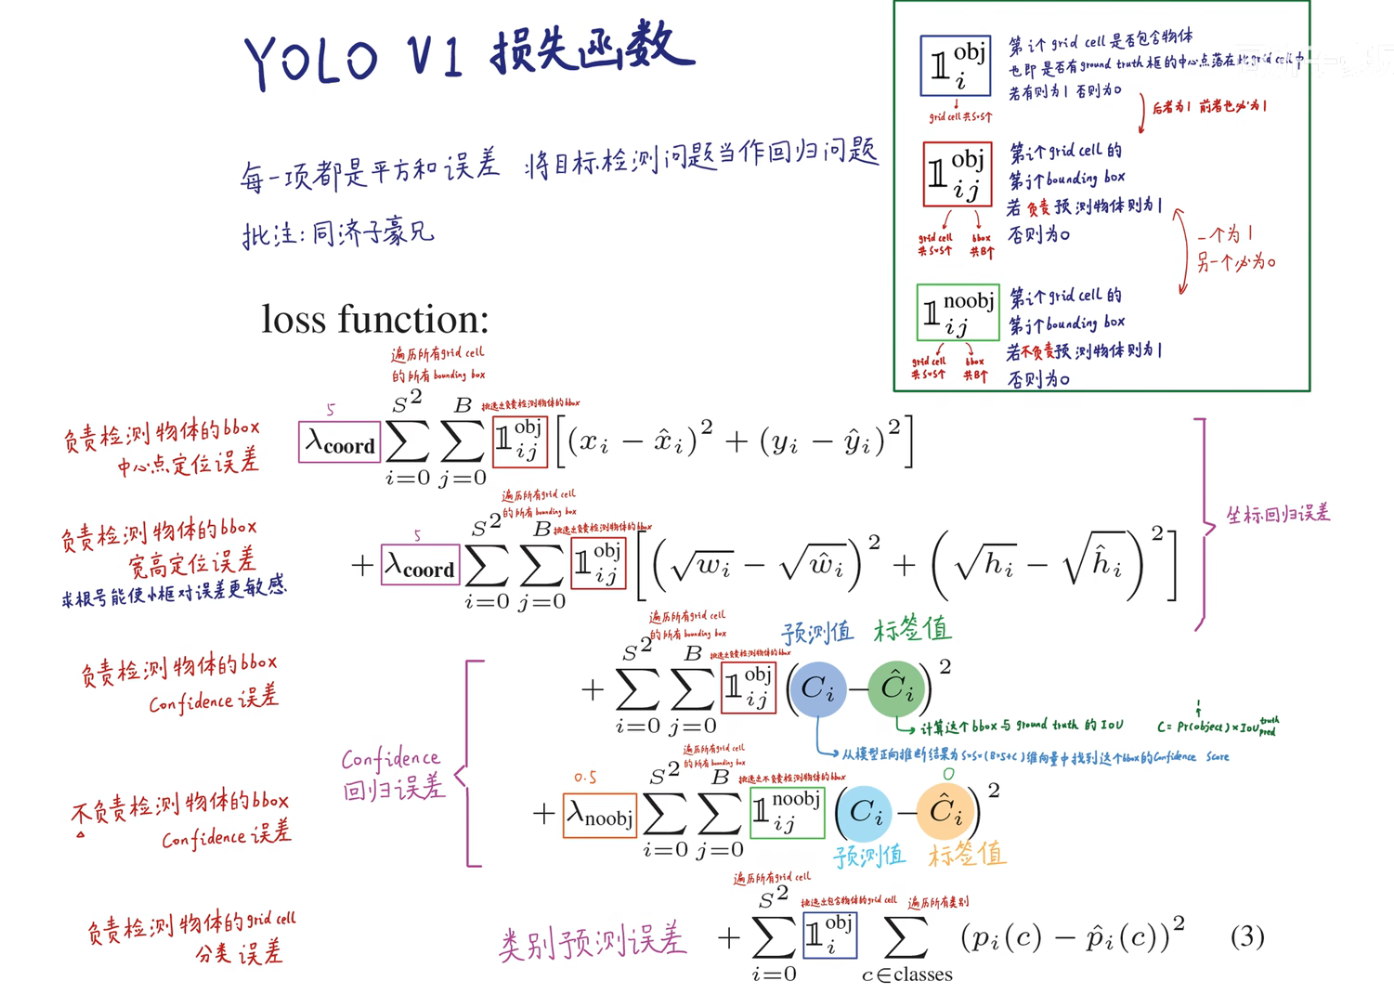

In [106]:

class YoloLoss(nn.Module):
    def __init__(self, S, B, l_coord, l_noobj):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj


    # return (pred.size(0),2)
    def compute_iou(self, pred, target):
        b = pred
        d = target
        cell_num = self.S
        cell_size = 1.0/cell_num

        xmin = torch.max(b[:, 0, :] * cell_size - b[:, 2, :]/2, d[:, 0, :]* cell_size  - d[:, 2, :]/2)
        xmax = torch.min(b[:, 0, :] * cell_size + b[:, 2, :]/2, d[:, 0, :]* cell_size  + d[:, 2, :]/2)
        ymin = torch.max(b[:, 1, :] * cell_size - b[:, 3, :]/2, d[:, 1, :]* cell_size  - d[:, 3, :]/2)
        ymax = torch.min(b[:, 1, :] * cell_size + b[:, 3, :]/2, d[:, 1, :]* cell_size  + d[:, 3, :]/2)

        interset = (xmax - xmin) * (ymax - ymin)
        union = b[:, 2, :] * b[:, 3, :] + d[:, 2, :] * d[:, 3, :] - interset
        iou = interset / union
        iou[iou < 0] = 0
        return iou

    def forward(self, pred_tensor, target_tensor):
        '''
        pred_tensor: (tensor) size(batchsize,S,S,Bx5+20=30) [x,y,w,h]   [batch, width, height, [x,y,w,h,是否有物体的confidence(IoU)]x2 + 1*20]
        target_tensor: (tensor) size(batchsize,S,S,30) --- 标签的准确格式
        '''
        N = pred_tensor.size()[0]
        obj_mask = target_tensor[:, :, :, 4] > 0   # 具有目标标签的索引
        noobj_mask = target_tensor[:, :, :, 4] == 0  # 不具有目标的标签索引

        obj_mask = obj_mask.unsqueeze(-1).expand_as(target_tensor)  # 得到含物体的坐标等信息
        noobj_mask = noobj_mask.unsqueeze(-1).expand_as(target_tensor)  # 得到不含物体的坐标等信息

        obj_pred = pred_tensor[obj_mask].view(-1, 30)
        obj_box_pred = obj_pred[:, :10]  # 预测框坐标相对值
        obj_class_pred = obj_pred[:, 10:]  # 分类条件概率

        obj_target = target_tensor[obj_mask].view(-1, 30)
        obj_box_target = obj_target[:, :10]
        obj_class_target = obj_target[:, 10:]

        b = torch.concat([obj_pred[:, 0:5].unsqueeze(-1), obj_pred[:, 5:10].unsqueeze(-1)], dim=2)
        d = torch.concat([obj_target[:, 0:5].unsqueeze(-1), obj_target[:, 5:10].unsqueeze(-1)], dim=2)
        iou_pred = torch.concat([obj_pred[:,4].unsqueeze(-1), obj_pred[:,9].unsqueeze(-1)], dim=1)
        iou_target = self.compute_iou(b, d) # 预测出来的框和groundtruth求iou,  (b.size(0),2)
        _, maxindex = torch.max(iou_target, dim=1)
        iou_nonmax_mask = torch.ones(b.shape[0], 1, b.shape[2]).to(config.device)
        iou_max_mask = torch.zeros(b.shape[0], 1, b.shape[2]).to(config.device)
        for i in range(maxindex.size(0)):
            iou_max_mask[i, :, maxindex[i]] = 1
            iou_nonmax_mask[i, :, maxindex[i]] = 0

        # 负责检测物体的中心点定位损失
        coord_center_pred = torch.stack((b[:, 0, :], b[:, 1, :]), dim=1) * iou_max_mask
        coord_center_target = torch.stack((d[:, 0, :], d[:, 1, :]), dim=1) * iou_max_mask
        coord_center_loss = F.mse_loss(coord_center_pred, coord_center_target, size_average=False)

        # 负责检测物体的长宽损失
        coord_wh_pred = torch.stack((torch.sqrt(b[:, 2, :]), torch.sqrt(b[:, 3, :])), dim=1) * iou_max_mask
        coord_wh_target = torch.stack((torch.sqrt(d[:, 2, :]), torch.sqrt(d[:, 3, :])), dim=1) * iou_max_mask
        coord_wh_loss = F.mse_loss(coord_wh_pred, coord_wh_target, size_average=False)

        # 负责检测物体的IoU损失
        obj_iou_pred = iou_pred * iou_max_mask.squeeze()
        obj_iou_target = iou_target * iou_max_mask.squeeze()
        iou_loss = F.mse_loss(obj_iou_pred, obj_iou_target, size_average=False)

        # 不负责检测物体的IoU损失
        iou_nonmax_pred = iou_pred * iou_nonmax_mask.squeeze()
        iou_nonmax_target = torch.zeros(iou_pred.size()).to(config.device) * iou_nonmax_mask.squeeze()
        iou_nonmax_loss = F.mse_loss(iou_nonmax_pred, iou_nonmax_target, size_average=False)
 
        noobj_pred = pred_tensor[noobj_mask].view(-1, 30)
        noobj_target = target_tensor[noobj_mask].view(-1, 30)
        noobj_pred_mask = torch.zeros(noobj_pred.size()).to(config.device)
        noobj_pred_mask[:, 4] = 1
        noobj_pred_mask[:, 9] = 1
        noobj_pred_c = noobj_pred * noobj_pred_mask
        noobj_target_c = noobj_target * noobj_pred_mask
        nooobj_iou_loss = F.mse_loss(noobj_pred_c, noobj_target_c, size_average=False)

        # 分类损失
        class_loss = F.mse_loss(obj_class_pred, obj_class_target, size_average=False)

        print(f"coord_center_loss {coord_center_loss:.4f} coord_wh_loss {coord_wh_loss:.4f} iou_loss {iou_loss:.4f} iou_nonmax_loss {iou_nonmax_loss:.4f} noobj_iou_loss {nooobj_iou_loss:.4f} class_loss {class_loss}")

        loss = self.l_coord * coord_center_loss \
            + self.l_coord * coord_wh_loss \
            + iou_loss \
            + self.l_noobj * (iou_nonmax_loss + nooobj_iou_loss) \
            + class_loss
        return loss / N

### train

In [107]:
train_dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

loss_fct = YoloLoss(7, 2, 5, 0.5)

# optimizer
from torch import optim
optimizer = optim.AdamW(model.parameters(), lr=config.lr)

# scheduler
num_epochs = config.epochs
num_training_steps = num_epochs * len(train_dataloader)
# lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

def lr_lambda(epoch):
    if epoch == 0:
        return 1e-3
    if epoch < 75:
        return 1e-2
    if epoch < 105:
        return 1e-3
    return 1e-4

lr_scheduler = optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda= lr_lambda,  #传入一个函数或一个以函数为元素列表，作为学习率调整的策略
    last_epoch=-1
)


print(num_training_steps)


# model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

total_batch_i = 0
model.train()
for epoch in range(num_epochs):
    for batch_i, (img, target) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(img.to(config.device))
        outputs = outputs.to(config.device)
        target = target.to(config.device)
        loss = loss_fct(outputs, target)
        
        # if total_batch_i % 100 == 0:
        #     print(f"epoch:{epoch} batch_i:{batch_i} loss:{loss.item()}")
        print(f"epoch:{epoch} batch_i:{batch_i} loss:{loss.item()}")
        if epoch % 5 == 0:
            torch.save(model.state_dict(), f"checkpoints/model_{epoch}_{batch_i}.pth")

        loss.backward()
        optimizer.step()
        total_batch_i = total_batch_i + 1
    lr_scheduler.step()

500100


/home/beyond/.local/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


coord_center_loss 0.7569 coord_wh_loss 0.0650 iou_loss 0.0451 iou_nonmax_loss 0.7237 noobj_iou_loss 27.8407 class_loss 12.300540924072266
epoch:0 batch_i:0 loss:30.73743438720703
coord_center_loss 0.7096 coord_wh_loss 0.0141 iou_loss 0.0198 iou_nonmax_loss 0.0881 noobj_iou_loss 28.4998 class_loss 6.052249431610107
epoch:0 batch_i:1 loss:23.984363555908203
coord_center_loss 0.8027 coord_wh_loss 0.2540 iou_loss 0.2420 iou_nonmax_loss 0.5918 noobj_iou_loss 27.7295 class_loss 5.673831462860107
epoch:0 batch_i:2 loss:25.359634399414062
coord_center_loss 0.1392 coord_wh_loss 0.0480 iou_loss 0.0549 iou_nonmax_loss 0.3688 noobj_iou_loss 27.7830 class_loss 6.794758319854736
epoch:0 batch_i:3 loss:21.86187171936035
coord_center_loss 0.0946 coord_wh_loss 0.1908 iou_loss 0.0766 iou_nonmax_loss 0.3338 noobj_iou_loss 27.6739 class_loss 5.672954082489014
epoch:0 batch_i:4 loss:21.180532455444336
coord_center_loss 1.6950 coord_wh_loss 1.4628 iou_loss 0.8557 iou_nonmax_loss 2.7028 noobj_iou_loss 24.815

In [ ]:
import torch
from torch.autograd import Variable

import torchvision.transforms as transforms
import cv2
import numpy as np
import os

VOC_CLASSES = [   # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'] 

Color = [[0, 0, 0],
         [128, 0, 0],
         [0, 128, 0],
         [128, 128, 0],
         [0, 0, 128],
         [128, 0, 128],
         [0, 128, 128],
         [128, 128, 128],
         [64, 0, 0],
         [192, 0, 0],
         [64, 128, 0],
         [192, 128, 0],
         [64, 0, 128],
         [192, 0, 128],
         [64, 128, 128],
         [192, 128, 128],
         [0, 64, 0],
         [128, 64, 0],
         [0, 192, 0],
         [128, 192, 0],
         [0, 64, 128]]


def compute_iou_matrix(a):
    iou_m = torch.ones((a.size(0), a.size(0)))
    for j in range(a.size(0)):
        for k in range(j+1, a.size(0)):
            xmin = torch.max(a[j,0] - a[j,2]/2, a[k,0]- a[j,2]/2) 
            xmax = torch.min(a[j,0] + a[j,2]/2, a[k,0]+ a[j,2]/2) 
            ymin = torch.max(a[j,1] - a[j,3]/2, a[k,1]- a[j,3]/2) 
            ymax = torch.min(a[j,1] + a[j,3]/2, a[k,1]+ a[j,3]/2) 
            interset = (xmax - xmin) * (ymax - ymin)
            union = a[j,2] * a[j,3] + a[k,2] * a[k,3] - interset
            iou = interset / union
            iou_m[j,k] = iou
            iou_m[k,j] = iou
    return iou_m
            

def decode(outputs):
    grid_num = 7
    cell_size = 1. / grid_num

    prob1 = outputs[:,:,:,4].unsqueeze(-1).expand_as(outputs[:,:,:,10:])  * outputs[:,:,:,10:] # softmax?
    prob2 = outputs[:,:,:,9].unsqueeze(-1).expand_as(outputs[:,:,:,10:])  * outputs[:,:,:,10:]
   
    x = torch.arange(0,7).to(config.device).unsqueeze(0).unsqueeze(0).expand_as(outputs[:,:,:,0])* cell_size + outputs[:,:,:,0] * cell_size
    y = torch.arange(0,7).to(config.device).unsqueeze(1).unsqueeze(0).expand_as(outputs[:,:,:,1])* cell_size + outputs[:,:,:,1] * cell_size
    wh  = outputs[:,:,:,2:4]
    real_coord = torch.concat([x.unsqueeze(-1),y.unsqueeze(-1), wh],dim=-1)
    

    x2 = torch.arange(0,7).to(config.device).unsqueeze(0).unsqueeze(0).expand_as(outputs[:,:,:,5])* cell_size + outputs[:,:,:,5] * cell_size
    y2 = torch.arange(0,7).to(config.device).unsqueeze(1).unsqueeze(0).expand_as(outputs[:,:,:,6])* cell_size + outputs[:,:,:,6] * cell_size
    wh2  = outputs[:,:,:,7:9]
    real_coord2 = torch.concat([x2.unsqueeze(-1),y2.unsqueeze(-1), wh2],dim=-1)
    
    
    a = torch.concat([real_coord[:,:,:,0:4], prob1], dim=-1)
    b = torch.concat([real_coord2[:,:,:,0:4], prob2], dim=-1)

    a = a.view(-1,24)
    b = b.view(-1,24)
    a = torch.cat([a,b], dim=0)
    iou_m = compute_iou_matrix(a)
    for i in range(4, 24):
        _,index = torch.sort(a[:,i], descending=True)
        for m in range(index.size(0)-1):
            j = index[m]
            if a[j,i] == 0:
                continue
            for n in range(m+1, index.size(0)):
                k = index[n]
                if a[k,i] == 0:
                    continue
                iou = iou_m[j,k]
                if iou > config.max_interset_iou:
                    a[k,i] = 0
    maxprob, maxindex  = torch.max(a[:,4:],dim=1)
    print(maxprob)
    print(maxindex)
    c = torch.concat([a[:,0:4], maxindex.unsqueeze(-1), maxprob.unsqueeze(-1)], dim=1)
    c[c[:,5] < config.min_confidence] = 0
    d = c[c[:,5] != 0]
    return d

def predict(model, image_name):

    result = []
    image = cv2.imread(image_name)
    h, w, _ = image.shape
    img = cv2.resize(image, (448, 448))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mean = (123, 117, 104)  # RGB
    img = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])(img)
    img = Variable(img[None, :, :, :], volatile=True)
    img = img.to(config.device)
    pred = model(img)  # 1x7x7x30
    print(pred)
    d = decode(pred)
    print(f"d : {d}")
    for i in range(d.size(0)):
        box = d[i, :4]
        x1 = int((box[0] - box[2]/2) * w)
        x2 = int((box[0] + box[2]/2) * w)
        y1 = int((box[1] - box[3]/2) * h)
        y2 = int((box[1] + box[3]/2) * h)
        cls_index = int(d[i,4].item())
        prob = float(d[i,5].item())
        result.append(
            [(x1, y1), (x2, y2), VOC_CLASSES[cls_index], image_name, prob])
    return result


if __name__ == '__main__':
    # model = resnet50(pretrained=True)
    print('load model...')
    model.eval()
    model.to(config.device)
    image_name = os.path.join(config.datasetdir, "JPEGImages", dataset.fnames[0])
    image = cv2.imread(image_name)
    print('predicting...')
    result = predict(model, image_name)
    print(result)
    for left_up, right_bottom, class_name, _, prob in result:
        color = Color[VOC_CLASSES.index(class_name)]
        cv2.rectangle(image, left_up, right_bottom, color, 2)
        label = class_name + str(round(prob, 2))
        text_size, baseline = cv2.getTextSize(
            label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        p1 = (left_up[0], left_up[1] - text_size[1])
        cv2.rectangle(image, (p1[0] - 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, - 1)
        cv2.putText(
            image,
            label,
            (p1[0],
             p1[1] +
                baseline),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,
            (255,
             255,
             255),
            1,
            8)
    # plt.imshow(image)
    cv2.imwrite('result.jpg', image)


load model...
predicting...


/tmp/ipykernel_948300/3267937216.py:198: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = Variable(img[None, :, :, :], volatile=True)


tensor([[[[0.2673, 0.2982, 0.6128,  ..., 0.5494, 0.4981, 0.5287],
          [0.3440, 0.2880, 0.7463,  ..., 0.5828, 0.6297, 0.5303],
          [0.3868, 0.3090, 0.7108,  ..., 0.5778, 0.6859, 0.5623],
          ...,
          [0.3778, 0.3086, 0.7298,  ..., 0.5936, 0.6653, 0.5976],
          [0.3303, 0.3631, 0.6670,  ..., 0.5971, 0.5579, 0.6548],
          [0.3685, 0.3697, 0.6809,  ..., 0.5918, 0.6180, 0.5590]],

         [[0.3053, 0.2998, 0.6205,  ..., 0.5462, 0.7050, 0.6251],
          [0.4529, 0.3313, 0.7931,  ..., 0.4596, 0.6816, 0.6887],
          [0.4422, 0.3552, 0.7438,  ..., 0.5652, 0.5284, 0.6804],
          ...,
          [0.5156, 0.3495, 0.7696,  ..., 0.6149, 0.5661, 0.6955],
          [0.3867, 0.6282, 0.6792,  ..., 0.5493, 0.5643, 0.7474],
          [0.4786, 0.4466, 0.7890,  ..., 0.6205, 0.7302, 0.6916]],

         [[0.3260, 0.3209, 0.6043,  ..., 0.5623, 0.7261, 0.7339],
          [0.4047, 0.5094, 0.7224,  ..., 0.6615, 0.7505, 0.7411],
          [0.4719, 0.5078, 0.7029,  ..., 0

### 显示groundtruth框用于测试

a : tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1429, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2857, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5714, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.7143, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.8571, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1429, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2857, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.5714, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.7143, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.8571, 0.1429, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.2857, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1429, 0.2857, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.2857, 0.2857, 0.0000,  ..

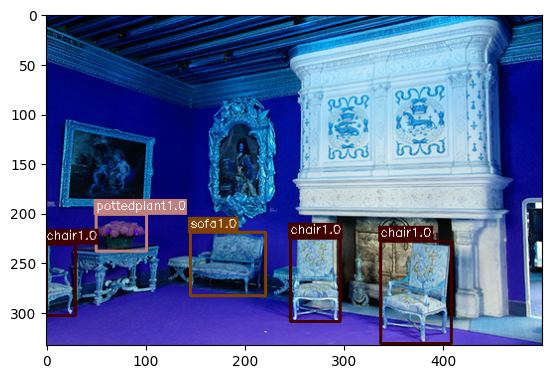

In [ ]:
import torch
from torch.autograd import Variable

import torchvision.transforms as transforms
import cv2
import numpy as np
import os

VOC_CLASSES = [   # always index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'] 

Color = [[0, 0, 0],
         [128, 0, 0],
         [0, 128, 0],
         [128, 128, 0],
         [0, 0, 128],
         [128, 0, 128],
         [0, 128, 128],
         [128, 128, 128],
         [64, 0, 0],
         [192, 0, 0],
         [64, 128, 0],
         [192, 128, 0],
         [64, 0, 128],
         [192, 0, 128],
         [64, 128, 128],
         [192, 128, 128],
         [0, 64, 0],
         [128, 64, 0],
         [0, 192, 0],
         [128, 192, 0],
         [0, 64, 128]]


model.to(config.device)
model.eval()

# pred = model(sample[0].unsqueeze(0).to(config.device))
# pred = pred.cpu()


sample = dataset[0][1]
d = decode(sample.unsqueeze(0).to(config.device))
result = []
image = cv2.imread(os.path.join(config.datasetdir, "JPEGImages", dataset.fnames[0]))

h,w,_ = image.shape
for i in range(d.size(0)):
    box = d[i, :4]
    x1 = int((box[0] - box[2]/2) * w)
    x2 = int((box[0] + box[2]/2) * w)
    y1 = int((box[1] - box[3]/2) * h)
    y2 = int((box[1] + box[3]/2) * h)
    cls_index = int(d[i,4].item())
    prob = float(d[i,5].item())
    result.append(
        [(x1, y1), (x2, y2), VOC_CLASSES[cls_index], image_name, prob])
print(f"decode boxes: {result}")


print(image.shape)
i = 0
for left_up, right_bottom, class_name, _, prob in result:
    color = Color[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, - 1)
    cv2.putText(
        image,
        label,
        (p1[0],
            p1[1] +
            baseline),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.4,
        (255,
            255,
            255),
        1,
        8)
plt.imshow(image)
# cv2.imwrite('result.jpg', image)

### evaluate

In [ ]:
def show(img,output):
    pass
